In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load dataset
folder = '/content/drive/My Drive/Colab Notebooks/HIA303 Health Data Analytics/'

In [3]:
# after cleaning the data
import pandas as pd
data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/HIA303 Health Data Analytics/breast-cancer-wisconsin-imputed.csv')
data

,sample_id,cl_thcknss,size_cell_un,shape_cell_un,marg_adhesion,size_cell_single,bare_nucl,bl_chrmatn,nrml_nucleo,mitoses,class
0,1000025,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2
1,1002945,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,2
2,1015425,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,2
3,1016277,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,2
4,1017023,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,2
695,841769,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2
696,888820,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,4
697,897471,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,4


In [8]:
data.shape

(699, 11)

In [10]:
#changing the value of the column id =1 as machine learning screening on id will not provide us insight
data.drop(['sample_id'], 1, inplace=True)

<ipython-input-10-6f995181f70a>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(['sample_id'], 1, inplace=True)


In [11]:
import seaborn as sns
import numpy as np
# Augmenting the data
def generateData(data1): 
    # make a copy of data 
    data2 = data1.copy()
    # separate labels from features
    diagnosis2 = data2['class'] # labels
    features2 = data2.drop(['class'], axis = 1)
    features2_headers =  ["cl_thcknss","size_cell_un","shape_cell_un","marg_adhesion","size_cell_single","bare_nucl","bl_chrmatn","nrml_nucleo","mitoses"]
    mean, sigma = 0, 0.1
    # creating a noise with the same dimension as the dataset
    noise = np.random.normal(mean, sigma, features2.shape)
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0) 
    data2 = pd.concat([features2_with_noise,  
                       pd.DataFrame(diagnosis2)], axis = 1)
    return data2

The above dataset generation function is called as following to combine a new generated dataset with the given dataset.

the new deep learning model requires the input values in the range of [0, 1] for better performance. To this end, the values of the dataset are scaled into the range of [0, 1] as follows:

In [12]:
new_data = generateData(data)
data = data.append(new_data, ignore_index=True)

Scaling Dataset

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical =["class","cl_thcknss","size_cell_un","shape_cell_un","marg_adhesion","size_cell_single","bare_nucl","bl_chrmatn","nrml_nucleo","mitoses"] 
data[numerical] = scaler.fit_transform(data[numerical])

Handling Dataset Skewness

the dataset skewness issue is handled by separating features from labels and then applying squared root transformation to the feature values only.

In [14]:

diagnosis = data['class']
features = data.drop(['class'], axis = 1) 
sqrt_features = features.copy()
for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
features = pd.DataFrame(sqrt_features)

Splitting Dataset into Training and Testing Subsets

In [15]:
# the dataset is split into two parts: 75% for model training and 25% for model testing:
from sklearn.model_selection import train_test_split
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features,   
    diagnosis, test_size=0.25, random_state=42)

Reformatting Dataset

In [16]:
# After splitting dataset, the resulting data subsets must be re-indexed as follows to avoid dataset key mismatch issue:
X_train = X_train.reset_index(drop=True) 
X_test = X_test.reset_index(drop=True) 
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)

Then the resulting Pandas DataFrames must be converted into Numpy arrays as below because the Pandas DataFrame is not supported by Keras API.

In [17]:
X_train = X_train.values 
y_train = y_train.values 
X_test = X_test.values 
y_test = y_test.values

The scikit-learn out-of-box implementation of the Random Forest Classifier is used to produce the benchmark prediction result for comparison

In [18]:
from sklearn.ensemble import RandomForestClassifier 

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)

Implementing the New Deep Learning Model

In [20]:
# a reusable function can be defined for creating new model instances
from keras.layers import Dense
from keras.layers import Dropout 
from keras.models import Sequential 
import keras.utils
from keras import utils as np_utils
def createModel():
    model = Sequential()
    model.add(Dense(9, activation='relu', input_dim=9))   
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu', input_shape=(9,)))   
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', input_shape=(5,)))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [21]:
model = createModel()
model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
33/33 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.6403
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.6899
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.7080
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.7510
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.7443
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.6063 - accuracy: 0.7615
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.7939
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.5680 - accuracy: 0.7910
Epoch 9/500
33/33 [==============================] - 0s 2ms/step - loss: 0.5411 - accuracy: 0.7977
Epoch 10/500
33/33 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.8263
Epoch 11/

a 10-fold cross validation is performed as follows to verify the robustness of the new deep learning model

In [37]:
from sklearn.model_selection import StratifiedKFold 
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
X = X_train 
Y = y_train
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=seed) 
cvscores = []
for train, test in kfold.split(X, Y):
    model = createModel()
    model.fit(X[train], Y[train], epochs=500, batch_size=10, 
              verbose=0)
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("{}: {:.2f}".format(model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("{:.2f} (+/- {:.2f})".format(np.mean(cvscores), np.std(cvscores)))

accuracy: 100.00
accuracy: 100.00
accuracy: 97.14
accuracy: 91.43
accuracy: 96.19
accuracy: 98.10
accuracy: 94.29
accuracy: 98.10
accuracy: 98.08
accuracy: 98.08
97.14 (+/- 2.48)


Finally the model testing is performed 

In [38]:
score = model.evaluate(X_test, y_test, batch_size=32)

11/11 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9657


In [39]:
#Define your architecture.
model = Sequential()
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 9)                 90        
                                                                 
 dropout_28 (Dropout)        (None, 9)                 0         
                                                                 
 dense_49 (Dense)            (None, 5)                 50        
                                                                 
 dropout_29 (Dropout)        (None, 5)                 0         
                                                                 
 dense_50 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compile NN Model
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc']) # ['binary_accuracy']

In [41]:
# model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=1)

Epoch 1/1000
66/66 [==============================] - 1s 2ms/step - loss: 0.7307 - acc: 0.4723
Epoch 2/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.6612 - acc: 0.5906
Epoch 3/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.6198 - acc: 0.7452
Epoch 4/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.5879 - acc: 0.8177
Epoch 5/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.5689 - acc: 0.8044
Epoch 6/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.5424 - acc: 0.8168
Epoch 7/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.5181 - acc: 0.8368
Epoch 8/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.4878 - acc: 0.8292
Epoch 9/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.4719 - acc: 0.8273
Epoch 10/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.4436 - acc: 0.8607
Epoch 11/1000
66/66 [============================

<class 'list'>


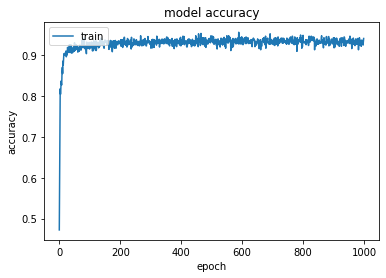

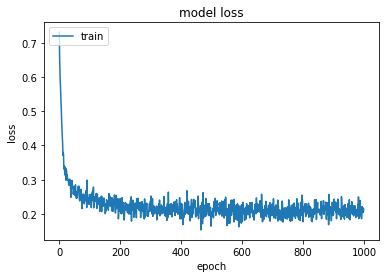

In [42]:
import matplotlib.pyplot as plt
print(type(history.history['acc']))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Test NN Model
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

22/22 [==============================] - 0s 2ms/step - loss: 0.0820 - acc: 0.9657
score =  [0.08203889429569244, 0.9657142758369446]


11/11 [==============================] - 0s 2ms/step


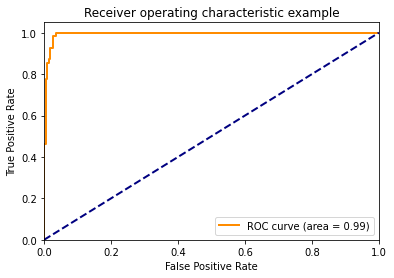

In [45]:
# Draw ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = predict_prob=model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()